<a href="https://colab.research.google.com/github/liminalvoid/nlp/blob/main/sem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Семинар: классический NLP-пайплайн (spaCy) + Zipf + правила

В этом ноутбуке мы:
1) загрузим текст (Project Gutenberg: *Pride and Prejudice*);
2) сделаем базовую предобработку и посчитаем **types/tokens**;
3) построим **Zipf-графики** и посмотрим **длинный хвост** (≤ 3);
4) запустим **классический NLP-пайплайн** в `spaCy` (токенизация → POS → зависимости → NER);
5) соберём **простую систему на правилах** (rule-based intent detector) для коротких пользовательских запросов.



In [ ]:
# (Colab) Установка зависимостей
!pip -q install spacy==3.7.5
!python -m spacy download en_core_web_sm -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 39.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 1) Загрузка данных (Gutenberg)

In [ ]:

import re
from collections import Counter
import requests

URL = "https://www.gutenberg.org/cache/epub/1342/pg1342.txt"

raw = requests.get(URL, timeout=30).text

# Уберём служебные заголовки/хвосты Gutenberg (если маркеры есть)
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"
start_idx = raw.find(start_marker)
end_idx = raw.find(end_marker)

text = raw
if start_idx != -1:
    text = raw[start_idx:]
    text = text.split("\n", 1)[1] if "\n" in text else text
if end_idx != -1 and end_idx > 0:
    text = text[:end_idx]

print("Длина текста (символов):", len(text))
print(text[:400])


Длина текста (символов): 744206




                            [Illustration:

                             GEORGE ALLEN
                               PUBLISHER

                        156 CHARING CROSS ROAD
                                LONDON

                             RUSKIN HOUSE
                                   ]

                            [Illustration:

               _Reading Jane’s Letters._


## 2) Токенизация, types/tokens, частоты

In [ ]:

# Простая токенизация для частот: слова из латинских букв + апострофы
tokens = re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?", text.lower())
cnt = Counter(tokens)

N_tokens = sum(cnt.values())  # tokens = все употребления
V_types = len(cnt)            # types  = уникальные слова

print(f"Tokens (всего словоупотреблений): {N_tokens:,}")
print(f"Types  (уникальных слов):        {V_types:,}")

# Топ-20
top20 = cnt.most_common(20)
top20[:10]


Tokens (всего словоупотреблений): 128,710
Types  (уникальных слов):        6,751


[('the', 4674),
 ('to', 4327),
 ('of', 3850),
 ('and', 3774),
 ('her', 2284),
 ('i', 2122),
 ('a', 2040),
 ('in', 1997),
 ('was', 1875),
 ('she', 1751)]

## 3) Zipf: rank–frequency (log–log) + топ-20 + длинный хвост ≤ 3

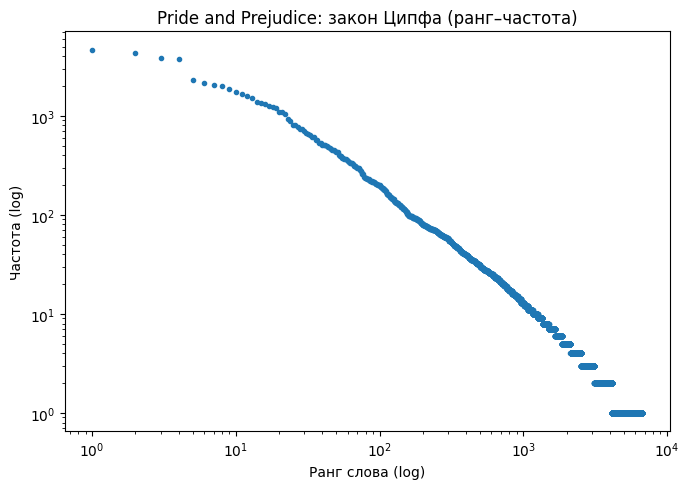

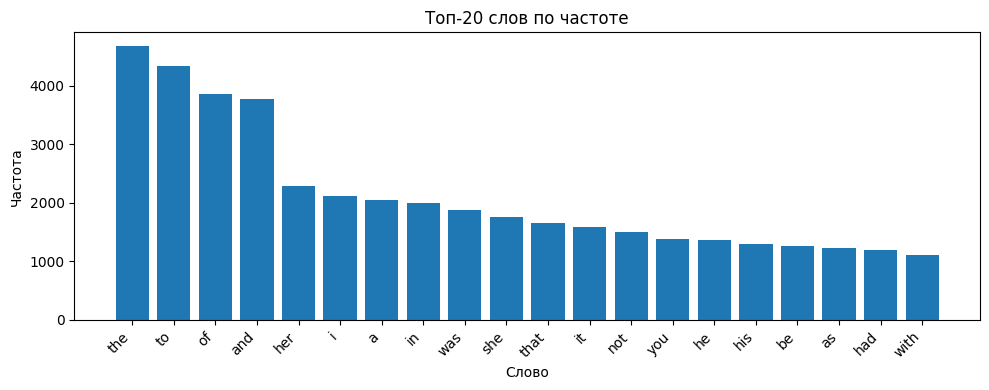

Хвост (c<=3): 4222 типов = 62.5% словаря
Хвост (c<=3): 6431 токенов = 5.0% текста


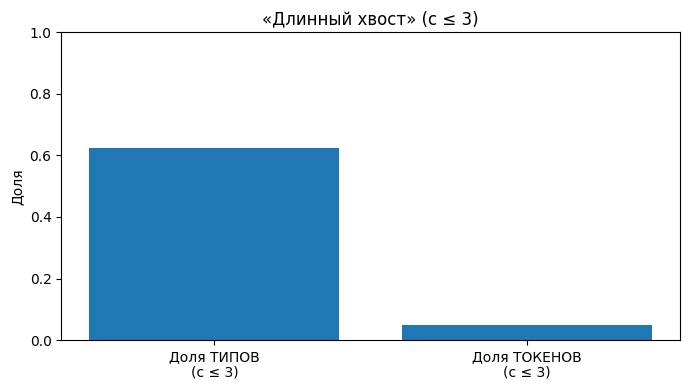

['gulf',
 'afflicting',
 'depreciate',
 'possessing',
 'disagreement',
 'thorpe',
 'exemption',
 'fetched',
 'symmetry',
 'kid']

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Zipf данные
freqs_sorted = np.array(sorted(cnt.values(), reverse=True))
ranks = np.arange(1, len(freqs_sorted) + 1)

# 3.1 Zipf log-log
plt.figure(figsize=(7,5))
plt.loglog(ranks, freqs_sorted, marker=".", linestyle="none")
plt.title("Pride and Prejudice: закон Ципфа (ранг–частота)")
plt.xlabel("Ранг слова (log)")
plt.ylabel("Частота (log)")
plt.tight_layout()
plt.show()

# 3.2 Топ-20
df_top20 = pd.DataFrame(top20, columns=["word","count"])
plt.figure(figsize=(10,4))
plt.bar(df_top20["word"], df_top20["count"])
plt.title("Топ-20 слов по частоте")
plt.xlabel("Слово")
plt.ylabel("Частота")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3.3 Длинный хвост: <= 3
tail_words = [w for w, c in cnt.items() if c <= 3]
tail_types = len(tail_words)
tail_tokens = sum(cnt[w] for w in tail_words)

print(f"Хвост (c<=3): {tail_types} типов = {tail_types/V_types:.1%} словаря")
print(f"Хвост (c<=3): {tail_tokens} токенов = {tail_tokens/N_tokens:.1%} текста")

plt.figure(figsize=(7,4))
plt.bar(["Доля ТИПОВ\n(c ≤ 3)", "Доля ТОКЕНОВ\n(c ≤ 3)"],
        [tail_types/V_types, tail_tokens/N_tokens])
plt.ylim(0, 1)
plt.title("«Длинный хвост» (c ≤ 3)")
plt.ylabel("Доля")
plt.tight_layout()
plt.show()

# 3.4 (Опционально) 10 случайных hapax (c=1)
hapax = [w for w, c in cnt.items() if c == 1]
rng = np.random.default_rng(0)
sample10 = list(rng.choice(hapax, size=10, replace=False))
sample10


## 4) Классический NLP-пайплайн в spaCy

In [ ]:

import spacy
nlp = spacy.load("en_core_web_sm")

doc = nlp("Mr. Darcy spoke politely, but Elizabeth did not change her mind about him. Then, he went to the table.")
print("SENTENCES:", [s.text for s in doc.sents])
print("TOKENS:", [t.text for t in doc])
print("POS:", [(t.text, t.pos_) for t in doc])
print("DEP:", [(t.text, t.dep_, t.head.text) for t in doc])

print("\nNER entities:")
for ent in doc.ents:
    print(ent.text, ent.label_)

for t in doc:
    print(f"{t.i:2d}  {t.text!r:12}  is_alpha={t.is_alpha}  is_punct={t.is_punct}")


SENTENCES: ['Mr. Darcy spoke politely, but Elizabeth did not change her mind about him.', 'Then, he went to the table.']
TOKENS: ['Mr.', 'Darcy', 'spoke', 'politely', ',', 'but', 'Elizabeth', 'did', 'not', 'change', 'her', 'mind', 'about', 'him', '.', 'Then', ',', 'he', 'went', 'to', 'the', 'table', '.']
POS: [('Mr.', 'PROPN'), ('Darcy', 'PROPN'), ('spoke', 'VERB'), ('politely', 'ADV'), (',', 'PUNCT'), ('but', 'CCONJ'), ('Elizabeth', 'PROPN'), ('did', 'AUX'), ('not', 'PART'), ('change', 'VERB'), ('her', 'PRON'), ('mind', 'NOUN'), ('about', 'ADP'), ('him', 'PRON'), ('.', 'PUNCT'), ('Then', 'ADV'), (',', 'PUNCT'), ('he', 'PRON'), ('went', 'VERB'), ('to', 'ADP'), ('the', 'DET'), ('table', 'NOUN'), ('.', 'PUNCT')]
DEP: [('Mr.', 'compound', 'Darcy'), ('Darcy', 'nsubj', 'spoke'), ('spoke', 'ROOT', 'spoke'), ('politely', 'advmod', 'spoke'), (',', 'punct', 'spoke'), ('but', 'cc', 'spoke'), ('Elizabeth', 'nsubj', 'change'), ('did', 'aux', 'change'), ('not', 'neg', 'change'), ('change', 'conj', 

### Применим пайплайн к реальному фрагменту из книги

In [ ]:

# Возьмём небольшой фрагмент (чтобы быстро работало)
snippet = " ".join(text.split()[:350])  # первые ~350 слов
doc = nlp(snippet)

# Посмотрим 15 токенов с POS/леммой
rows = []
for t in list(doc)[:15]:
    rows.append([t.text, t.lemma_, t.pos_, t.tag_])
pd.DataFrame(rows, columns=["token","lemma","POS","TAG"])


,token,lemma,POS,TAG
0,[,[,X,XX
1,Illustration,illustration,NOUN,NN
2,:,:,PUNCT,:
3,GEORGE,GEORGE,PROPN,NNP
4,ALLEN,ALLEN,PROPN,NNP
5,PUBLISHER,PUBLISHER,PROPN,NNP
6,156,156,NUM,CD
7,CHARING,CHARING,PROPN,NNP
8,CROSS,CROSS,PROPN,NNP
9,ROAD,ROAD,PROPN,NNP


## 5) Простая rule-based система: определение интентов


Сделаем игрушечный **intent detector** для пользовательских сообщений:
- greeting / goodbye
- ask_weather
- ask_time
- math_addition
- other

Подход:
- регулярки + `spaCy Matcher`.


In [ ]:

from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

pattern_greet = [{"LOWER": {"IN": ["hi","hello","hey","greetings"]}}]
pattern_goodbye = [{"LOWER": {"IN": ["bye","goodbye","farewell"]}}]
pattern_weather = [{"LOWER": {"IN": ["weather","rain","sunny","forecast"]}}]
pattern_time = [{"LOWER": {"IN": ["time","clock"]}}]

pattern_add_1 = [{"LOWER": "add"}, {"IS_DIGIT": True}, {"LOWER": "to"}, {"IS_DIGIT": True}]
pattern_add_2 = [{"IS_DIGIT": True}, {"TEXT": "+"}, {"IS_DIGIT": True}]

matcher.add("GREET", [pattern_greet])
matcher.add("GOODBYE", [pattern_goodbye])
matcher.add("WEATHER", [pattern_weather])
matcher.add("TIME", [pattern_time])
matcher.add("ADD", [pattern_add_1, pattern_add_2])

def detect_intent(text: str):
    doc = nlp(text)
    matches = matcher(doc)
    labels = [nlp.vocab.strings[m_id] for m_id, _, _ in matches]

    if "ADD" in labels:
        nums = [int(t.text) for t in doc if t.like_num]
        if len(nums) >= 2:
            return "math_addition", nums[0] + nums[1]
        return "math_addition", None
    if "WEATHER" in labels:
        return "ask_weather", None
    if "TIME" in labels:
        return "ask_time", None
    if "GREET" in labels:
        return "greeting", None
    if "GOODBYE" in labels:
        return "goodbye", None
    return "other", None

tests = [
    "Hello!",
    "Add 34957 to 70764",
    "What is 2 + 2 ?",
    "What's the weather tomorrow?",
    "What time is it now?",
    "Goodbye!",
    "Explain Zipf's law in one sentence."
]

for s in tests:
    intent, val = detect_intent(s)
    print(f"{s!r} -> {intent}", (f"(value={val})" if val is not None else ""))


'Hello!' -> greeting 
'Add 34957 to 70764' -> math_addition (value=105721)
'What is 2 + 2 ?' -> math_addition (value=4)
"What's the weather tomorrow?" -> ask_weather 
'What time is it now?' -> ask_time 
'Goodbye!' -> goodbye 
"Explain Zipf's law in one sentence." -> other 


## Домашняя мини-задача (5–10 минут)


1) Возьмите **русский роман** (любой .txt) и повторите блок **Zipf + длинный хвост**.
2) Сравните предобработки: lowercasing, удаление пунктуации, замена "ё"→"е", лемматизация (если есть инструменты).
3) Добавьте 2 новых интента и правила (Matcher/regex).


# Дополнение: русский язык — лемматизация, стемминг, POS/DEP/NER

В этом разделе:
1) покажем **лемматизацию** для русского (два варианта: `spaCy` и `pymorphy3`),
2) покажем **стемминг** (SnowballStemmer),
3) запустим **классический NLP-пайплайн** для русского: POS → синтаксические зависимости (DEP) → NER.


## 6) Установка русских инструментов

- `ru_core_news_sm` — русская модель spaCy (токены, леммы, POS, зависимости, NER)
- `pymorphy3` — сильный морфологический анализатор/лемматизатор для русского
- `nltk` — стемминг (SnowballStemmer)


In [ ]:
# (Colab) Установка для русского
!pip -q install spacy==3.7.5  nltk
!python -m spacy download ru_core_news_sm -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 51.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 7) Пример русского текста


In [ ]:
ru_text = (
    "Вчера Анна Каренина приехала в Москву.\n"
    "Она встретилась с братом Стивой в ресторане и долго говорила о семье и поездке.\n"
)
print(ru_text)


Вчера Анна Каренина приехала в Москву.
Она встретилась с братом Стивой в ресторане и долго говорила о семье и поездке.



## 8) Лемматизация и стемминг (русский)

Сравним:
- **леммы** (нормальная форма слова) — полезно для словаря/частот;
- **стеммы** (усечённые основы) — грубее, но быстро и просто.


In [ ]:
import re

# Базовая токенизация для русского (буквы + дефис)
ru_tokens = re.findall(r"[А-Яа-яЁё]+(?:-[А-Яа-яЁё]+)?", ru_text.lower())
print("Токены:", ru_tokens)


Токены: ['вчера', 'анна', 'каренина', 'приехала', 'в', 'москву', 'она', 'встретилась', 'с', 'братом', 'стивой', 'в', 'ресторане', 'и', 'долго', 'говорила', 'о', 'семье', 'и', 'поездке']


In [ ]:
# 8.1 Стемминг (Snowball)
import nltk
from nltk.stem.snowball import SnowballStemmer

nltk.download("punkt", quiet=True)
stemmer = SnowballStemmer("russian")

ru_stems = [stemmer.stem(w) for w in ru_tokens]
print(list(zip(ru_tokens, ru_stems)))


[('вчера', 'вчер'), ('анна', 'ан'), ('каренина', 'каренин'), ('приехала', 'приеха'), ('в', 'в'), ('москву', 'москв'), ('она', 'он'), ('встретилась', 'встрет'), ('с', 'с'), ('братом', 'брат'), ('стивой', 'стив'), ('в', 'в'), ('ресторане', 'ресторан'), ('и', 'и'), ('долго', 'долг'), ('говорила', 'говор'), ('о', 'о'), ('семье', 'сем'), ('и', 'и'), ('поездке', 'поездк')]


### 8.2 Лемматизация через pymorphy2 (обычно лучше для русского)

In [ ]:
!pip -q install pymorphy3 pymorphy3-dicts-ru

In [ ]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

ru_lemmas_pym = [morph.parse(w)[0].normal_form for w in ru_tokens]
print(list(zip(ru_tokens, ru_lemmas_pym)))


[('вчера', 'вчера'), ('анна', 'анна'), ('каренина', 'каренин'), ('приехала', 'приехать'), ('в', 'в'), ('москву', 'москва'), ('она', 'она'), ('встретилась', 'встретиться'), ('с', 'с'), ('братом', 'брат'), ('стивой', 'стива'), ('в', 'в'), ('ресторане', 'ресторан'), ('и', 'и'), ('долго', 'долго'), ('говорила', 'говорить'), ('о', 'о'), ('семье', 'семья'), ('и', 'и'), ('поездке', 'поездка')]


### 8.3 Лемматизация через spaCy (удобно, когда вы и так используете пайплайн)

In [ ]:
import spacy
from spacy import displacy

nlp_ru = spacy.load("ru_core_news_sm")

doc_ru = nlp_ru(ru_text)
print([(t.text, t.lemma_, t.pos_) for t in doc_ru if t.is_alpha])

displacy.render(doc_ru, style="dep", jupyter=True, options={"distance": 90})


[('Вчера', 'вчера', 'ADV'), ('Анна', 'анна', 'PROPN'), ('Каренина', 'каренин', 'PROPN'), ('приехала', 'приехать', 'VERB'), ('в', 'в', 'ADP'), ('Москву', 'москва', 'PROPN'), ('Она', 'она', 'PRON'), ('встретилась', 'встретиться', 'VERB'), ('с', 'с', 'ADP'), ('братом', 'брат', 'NOUN'), ('Стивой', 'стивой', 'PROPN'), ('в', 'в', 'ADP'), ('ресторане', 'ресторан', 'NOUN'), ('и', 'и', 'CCONJ'), ('долго', 'долго', 'ADV'), ('говорила', 'говорить', 'VERB'), ('о', 'о', 'ADP'), ('семье', 'семья', 'NOUN'), ('и', 'и', 'CCONJ'), ('поездке', 'поездка', 'NOUN')]


## 9) POS-теги + синтаксические зависимости (DEP) + NER для русского

In [ ]:
import pandas as pd

# 9.1 POS + морфология
rows = []
for t in doc_ru:
    if t.is_space:
        continue
    rows.append([t.text, t.lemma_, t.pos_, t.tag_, t.morph.to_json()])
pd.DataFrame(rows, columns=["token","lemma","POS","TAG","morph"])


,token,lemma,POS,TAG,morph
0,Вчера,вчера,ADV,ADV,Degree=Pos
1,Анна,анна,PROPN,PROPN,Animacy=Anim|Case=Nom|Gender=Fem|Number=Sing
2,Каренина,каренин,PROPN,PROPN,Animacy=Anim|Case=Nom|Gender=Fem|Number=Sing
3,приехала,приехать,VERB,VERB,Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Te...
4,в,в,ADP,ADP,
5,Москву,москва,PROPN,PROPN,Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing
6,.,.,PUNCT,PUNCT,
7,Она,она,PRON,PRON,Case=Nom|Gender=Fem|Number=Sing|Person=Third
8,встретилась,встретиться,VERB,VERB,Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Te...
9,с,с,ADP,ADP,


In [ ]:
# 9.2 Синтаксические зависимости (DEP): token -> head
dep_rows = []
for t in doc_ru:
    if t.is_space:
        continue
    dep_rows.append([t.text, t.dep_, t.head.text])
pd.DataFrame(dep_rows, columns=["token","dep","head"])


,token,dep,head
0,Вчера,advmod,приехала
1,Анна,nsubj,приехала
2,Каренина,flat:name,Анна
3,приехала,ROOT,приехала
4,в,case,Москву
5,Москву,obl,приехала
6,.,punct,приехала
7,Она,nsubj,встретилась
8,встретилась,ROOT,встретилась
9,с,case,братом


In [ ]:
# 9.3 NER (именованные сущности)
[(ent.text, ent.label_) for ent in doc_ru.ents]


[('Анна Каренина', 'PER'), ('Москву', 'LOC'), ('Стивой', 'PER')]

## Матчеры на основе тэгов

In [ ]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

pattern_superl_noun = [
    {"POS": "DET", "OP": "?"},  # optional: the/a
    {"POS": "ADJ", "TAG": {"IN": ["JJS"]}},  # superlative adj: best, worst
    {"POS": "NOUN"}
]
matcher.add("SUPERL_NOUN", [pattern_superl_noun])

doc = nlp("This is the best book and the worst idea.")
for mid, start, end in matcher(doc):
    print(nlp.vocab.strings[mid], doc[start:end].text)


SUPERL_NOUN the best book
SUPERL_NOUN best book
SUPERL_NOUN the worst idea
SUPERL_NOUN worst idea


In [ ]:
pattern_past_verb_object = [
    {"POS": "VERB", "TAG": "VBD"},            # past tense verb
    {"POS": "DET", "OP": "?"},                # optional determiner
    {"POS": {"IN": ["NOUN", "PROPN"]}}        # object-ish noun
]
matcher.add("PAST_VERB_OBJ", [pattern_past_verb_object])

doc = nlp("She visited London and bought a car yesterday.")
for mid, start, end in matcher(doc):
    print(nlp.vocab.strings[mid], doc[start:end].text)


PAST_VERB_OBJ visited London
PAST_VERB_OBJ bought a car


In [ ]:
pattern_np = [
    {"POS": "DET", "OP": "?"},
    {"POS": "ADJ", "OP": "*"},
    {"POS": {"IN": ["NOUN", "PROPN"]}}
]
matcher.add("NP_RULE", [pattern_np])

doc = nlp("I saw a very old house and Mr. Darcy.")
for mid, start, end in matcher(doc):
    print(doc[start:end].text)


old house
house
Mr.
Darcy


In [ ]:
pattern_question = [
    {"POS": "AUX"},
    {"POS": "PRON"},
    {"POS": "VERB"}
]
matcher.add("QUESTION_AUX_PRON_VERB", [pattern_question])

doc = nlp("Do you know Zipf's law? Can you help me?")
for mid, start, end in matcher(doc):
    print(nlp.vocab.strings[mid], doc[start:end].text)


QUESTION_AUX_PRON_VERB Do you know
NP_RULE Zipf
NP_RULE law
QUESTION_AUX_PRON_VERB Can you help


In [ ]:
from spacy.matcher import Matcher
matcher = Matcher(nlp_ru.vocab)

pattern_adj_noun = [
    {"POS": "ADJ"},
    {"POS": "NOUN"}
]
matcher.add("ADJ_NOUN", [pattern_adj_noun])

doc = nlp_ru("Старый дом стоял на тихой улице.")
for mid, start, end in matcher(doc):
    print(nlp_ru.vocab.strings[mid], doc[start:end].text)


ADJ_NOUN Старый дом
ADJ_NOUN тихой улице


## 10) Мини-задача для семинара (русский)

1) Возьмите фрагмент русского романа (например, 30–100k символов).
2) Сравните частоты **по токенам**, **по стеммам**, **по леммам**:
   - Как меняются топ-20?
   - Как меняется доля “длинного хвоста” (≤3) по **types**?
3) Выберите 5 предложений и сравните:
   - POS/DEP/NER от `spaCy`
   - леммы от `pymorphy3`
4) Составьте список имен персонажей
5) Найдите как можно больше предложений, где здороваются
